In [51]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from collections import deque, namedtuple

Building the AI - Creating the architecture of the Neural Network

In [52]:
class Network(nn.Module):
    def __init__(self,state_size,action_size,seed = 42):
        super(Network, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,action_size)
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

Training the AI

In [53]:
import gymnasium as gym
print(gym.envs.registry)
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n
print('State shape: ', state_shape)
print('State_size: ', state_size)
print('Number of actions: ', number_actions)

{'CartPole-v0': EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), 'CartPole-v1': EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), 'MountainCar-v0': EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, disable_env_ch

In [54]:
learning_rate = 5e-4
minibatch_size = 100
discount_factor = 0.99
replay_buffer_size = int(1e5)
interpolation_parameter = 1e-3

In [55]:
class ReplayMemory(object):
    def __init__(self,capacity):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.capacity = capacity
        self.memory = []
    def push(self,event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0]
    def sample(self,batch_size):
        experiences = random.sample(self.memory,k=batch_size)
        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        return states,next_states,actions,rewards,dones

In [56]:
class Agent():
    def __init__(self,state_size,action_size):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.state_size = state_size
        self.action_size = action_size
        self.local_qnetwork = Network(state_size,action_size).to(self.device)
        self.target_qnetwork = Network(state_size,action_size).to(self.device)
        self.optimizer = optim.Adam(self.local_qnetwork.parameters(),lr=learning_rate)
        self.memory = ReplayMemory(replay_buffer_size)
        self.t_step = 0
    def step(self,state,action,reward,next_state,done):
        self.memory.push((state,action,reward,next_state,done))
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory.memory) > minibatch_size:
                experiences = self.memory.sample(100)
                self.learn(experiences,discount_factor)
    def act(self,state,epsilon=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.local_qnetwork.eval()
        with torch.no_grad():
            action_values = self.local_qnetwork(state)
        self.local_qnetwork.train()
        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    def learn(self,experiences,discount_factor):
        states,next_states,actions,rewards,dones = experiences
        next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + (discount_factor * next_q_targets * (1 - dones))
        actions = actions.type(torch.LongTensor).to(self.device)
        q_expected = self.local_qnetwork(states).gather(1,actions)
        loss = F.mse_loss(q_expected,q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.local_qnetwork,self.target_qnetwork,interpolation_factor)
    def soft_update(self,local_model,target_model,interpolation_factor):
        for target_param,local_param in zip(target_model.parameters(),local_model.parameters()):
            target_param.data.copy_(interpolation_factor*local_param.data + (1.0-interpolation_factor)*target_param.data)


In [57]:
agent = Agent(state_size,number_actions)#Initilize the DQN agent

In [58]:
number_episodes = 2000
maximum_number_timesteps_per_episode = 1000
epsilon_starting_value  = 1.0
epsilon_ending_value  = 0.01
epsilon_decay_value  = 0.995
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)

for episode in range(1, number_episodes + 1):
  state, _ = env.reset()
  score = 0
  for t in range(maximum_number_timesteps_per_episode):
    action = agent.act(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    agent.step(state, action, reward, next_state, done)
    state = next_state
    score += reward
    if done:
      break
  scores_on_100_episodes.append(score)
  epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
  print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)), end = "")
  if episode % 100 == 0:
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))
  if np.mean(scores_on_100_episodes) >= 200.0:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_on_100_episodes)))
    torch.save(agent.local_qnetwork.state_dict(), 'checkpoint.pth')
    break

Episode 100	Average Score: -167.30
Episode 200	Average Score: -103.01
Episode 300	Average Score: -26.635
Episode 400	Average Score: -13.55
Episode 500	Average Score: 123.01
Episode 568	Average Score: 202.25
Environment solved in 468 episodes!	Average Score: 202.25


Visualize the Result

GIF saved successfully.



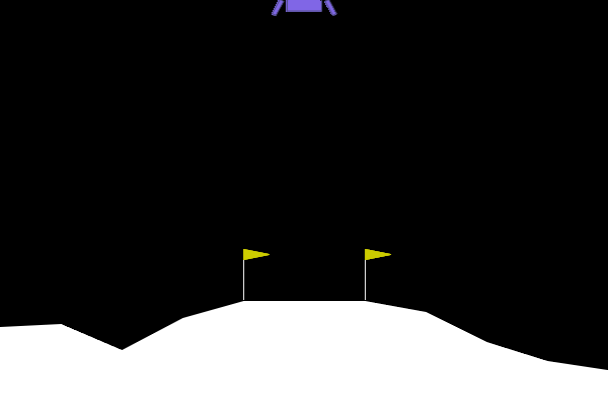

In [59]:
import cv2
import glob
import io
import base64
import imageio
import numpy as np
from IPython.display import HTML, display
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import gymnasium as gym

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []

    while not done:
        frame = env.render()
        resized_frame = cv2.resize(np.array(frame), (608, 400))  # Resize to fixed size
        frames.append(resized_frame)
        action = agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()
    # Save the frames as GIF instead of MP4
    imageio.mimsave('video.gif', frames, format='GIF', fps=30)
    print("GIF saved successfully.")

def show_video():
    gif_list = glob.glob('*.gif')
    if len(gif_list) > 0:
        gif_file = gif_list[0]
        video = io.open(gif_file, 'rb').read()
        encoded = base64.b64encode(video).decode('ascii')
        display(HTML(f'<img src="data:image/gif;base64,{encoded}" style="height: 400px;" autoplay loop>'))
    else:
        print("Could not find GIF")

# Run the functions
show_video_of_model(agent, 'LunarLander-v3')
show_video()
